<a href="https://colab.research.google.com/github/Dhagash4/Dhagash-Desai/blob/master/floor_sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os, cv2

from scipy.spatial.distance import cdist
from sklearn.decomposition.pca import PCA


from keras import backend as K
from keras.applications.resnet50 import ResNet50 as CNN

os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [0]:
dPath = "/content/drive/My Drive/Data/phone_images/"

In [0]:
imgReso = np.array([256,512])
def loadImg(p1,idx,res=imgReso,nameformat = "img_{0:07d}.png"):
    """
    Images will be resized to res=256x512 by default
    """
#     if idx % 20 == 0:
      
#     print (os.path.join(p1,nameformat.format(idx)))
      
    im1 = cv2.imread(os.path.join(p1,nameformat.format(idx)))
#     print(im1.shape)
    if res is not None:
        im1 = cv2.resize(im1,(res[1],res[0]),None)
    return im1

## Extract Features - Keras  

In [5]:
model = CNN( weights='imagenet', include_top=False)
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
layerName = "activation_25"#"block3_conv1"#"activation_49"
get_layer_output = K.function(
[model.layers[0].input, K.learning_phase()],[model.get_layer(layerName).output])

def getImageFeatures(inImg):
    ft = get_layer_output([np.expand_dims(inImg,axis=0),0])[0][0]
    imgFt = ft.flatten()  
#     print(imgFt.shape)
    return imgFt

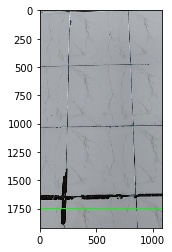

In [7]:
im1 = loadImg(dPath,172,None,'img_{0:07d}.jpg')
im1 = cv2.rectangle(im1,(0,0),(1080,1750),(0,255,0),4)
# print (type(im1))
# im1 = im1[850:1040,520:1440].copy()
plt.imshow(im1)

In [8]:
ft1 = np.array([getImageFeatures(cv2.resize(loadImg(dPath,i1+1,None,'img_{0:07d}.jpg')[0:1750,0:1080],None,None,0.125,0.5)) for i1 in range(0,len(os.listdir(dPath)),4)])
np.savez("/content/drive/My Drive/r50_imageNet_a22.npz",ft1)
print("Extraction complete for set 1...")
# ft2 = np.array([getImageFeatures(np.flipud(np.fliplr(cv2.resize(loadImg(dPath,i1+1,None,'img_{0:07d}.jpg')[0:1750,0:1080],None,None,0.125,0.5))) for i1 in range(0,len(os.listdir(dPath)),4)])
ft2 = np.array([getImageFeatures(np.fliplr(np.flipud(cv2.resize(loadImg(dPath,i1+1,None,'img_{0:07d}.jpg')[0:1750,0:1080],None,None,0.125,0.5)))) for i1 in range(0,len(os.listdir(dPath)),4)])
np.savez("/content/drive/My Drive/r50_imageNet_a22_flip.npz",ft2)
print("Extraction complete for set 2...")


Extraction complete for set 1...
Extraction complete for set 2...


## Load and Process stored features  

In [9]:
ft1 = np.load("/content/drive/My Drive/r50_imageNet_a22.npz")['arr_0']
print(ft1.shape)
pca = PCA(0.99)
ft1_ = pca.fit_transform(ft1)
print(ft1_.shape)
del ft1


ft2 = np.load("/content/drive/My Drive/r50_imageNet_a22_flip.npz")['arr_0']
print(ft2.shape)
ft2_ = pca.transform(ft2)
print(ft2_.shape)
del ft2

(343, 506880)
(343, 328)
(343, 506880)
(343, 328)


## Place Recognition

In [10]:
distMat = cdist(ft1_,ft2_,"cosine")
print("Distance matrix shape:", distMat.shape)

Distance matrix shape: (343, 343)


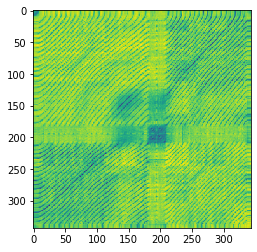

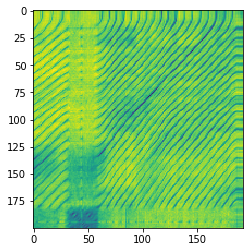

In [11]:
plt.imshow(distMat)
plt.show()
plt.imshow(distMat[0:200,:][:,150:350])
plt.show()

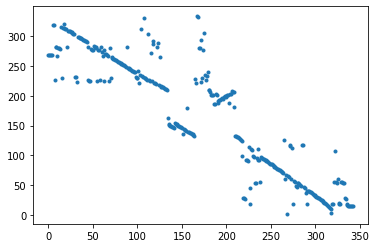

In [12]:
matchInds = np.argmin(distMat,axis=0)
plt.plot(matchInds,'.')
# plt.xlim(2400,3500)
plt.show()

### Sequence-Based Matching 

In [0]:
def getRangePushed(idx,l,mx):
    lbOrg = idx-l//2
    ubOrg = idx+l-l//2
    lb = lbOrg
    ub = ubOrg
    sIdxVal = 0 # index of first valid index (>=0)
    eIdxVal = l # index of last valid index (<=mx-1)
    if lb<0:
        sIdxVal = abs(lb) # for example if lb is -5, 5th index value would be 0
        lb=0
        ub=l
    elif ub>mx:
        eIdxVal = l-(ub-mx) # for example if ub is 102 for mx=100, l-1 would be the last valid idx (ub & eIdxVal are both non-inclusive)
        lb = mx-l
        ub = mx 
    return np.arange(lb,ub,1), np.arange(lbOrg,ubOrg,1), sIdxVal,eIdxVal

def seqSLAM_dm(seq,rSeqIndsPreComp,disMat):
        
    seqMatchInds,qSearchListLen = [],[]
    for qIndIter in range(disMat.shape[1]):
            
        qInd = qIndIter

        _,qSeqIndsOrg,qi_vs,qi_ve = getRangePushed(qInd,seq,disMat.shape[1])#np.arange(max(q1-seq//2,0), min(q1+(seq-seq//2),maxValQ))
            
        qi = qSeqIndsOrg   
        
        rInds2Proc = np.arange(disMat.shape[0])
        
        # check seq matches at all ref inds
        sMatchVals = []
#         qi = np.arange(disMat.shape[1])
        for r1 in rInds2Proc:
            ri = rSeqIndsPreComp[r1][:-2]
            ri_vs, ri_ve = rSeqIndsPreComp[r1][-2:]
            csi, cei = max(qi_vs,ri_vs), min(qi_ve,ri_ve) # conforming range indices between ref and query
            scores = np.mean(disMat[ri[csi:cei],qi[csi:cei]])
            sMatchVals.append(scores)
        qSearchListLen.append(len(rInds2Proc))
        seqMatchInds.append(rInds2Proc[np.argmin(sMatchVals)])
    return seqMatchInds,qSearchListLen

In [14]:
dMat = np.fliplr(distMat[0:200,:][:,150:350])
sVal = 1
maxValR = dMat.shape[0]
dm_numTopRef = None
print("Precompute sequence inds for ref...")
rIndsPreComp = []
for r1 in range(maxValR):
    rSeqInds,rSeqIndsOrg,rVs,rVe = getRangePushed(r1,sVal,maxValR)  
    rSeqIndsOrg = rSeqIndsOrg.tolist()
    rSeqIndsOrg.append(rVs)
    rSeqIndsOrg.append(rVe)
    rIndsPreComp.append(np.array(rSeqIndsOrg))
print("Precomputation complete.")

print("Running sequence matching...")

seqMatchInds, something = seqSLAM_dm(sVal,rIndsPreComp,dMat)
print("Sequence Matching Completed.")

Precompute sequence inds for ref...
Precomputation complete.
Running sequence matching...
Sequence Matching Completed.


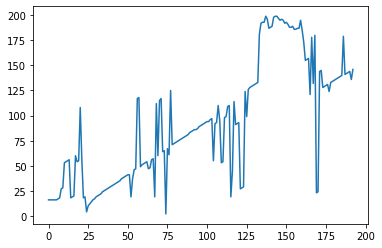

In [15]:
plt.plot(seqMatchInds)

**Satyajit's Code based on Matching Index**

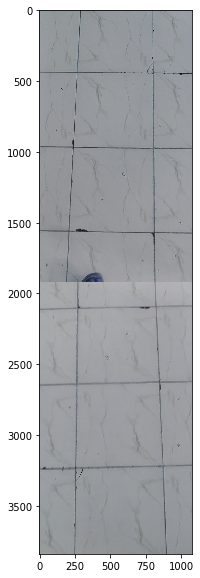

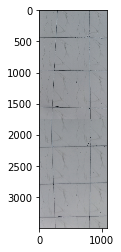

In [24]:
qIdx = 110
matchInds = np.argmin(distMat,axis=0)
# print(matchInds.shape)
ansIdx = matchInds[qIdx]
im1 = loadImg(dPath,qIdx*4,None,'img_{0:07d}.jpg')
im2 = loadImg(dPath,(ansIdx*4),None,'img_{0:07d}.jpg')
imStackRaw = np.vstack([im1,im2])
im1 = im1[0:1750, 0:1080].copy()
# im2 = im2[850:1040,520:1440].copy()
im2 = np.flipud(np.fliplr(im2[0:1750, 0:1080].copy()))
imStackCropped = np.vstack([im1,im2])

plt.figure(figsize=(15,10))
plt.imshow(imStackRaw)
plt.show()
plt.imshow(imStackCropped)

## Visualize Matches 

308


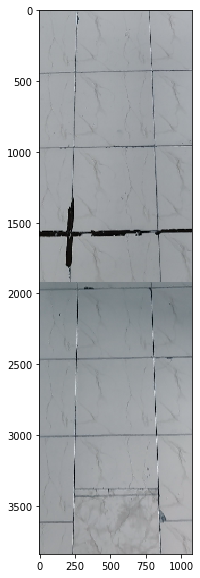

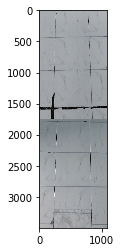

In [0]:
qIdx = 42


im1 = loadImg(dPath,qIdx*4,None,'img_{0:07d}.jpg')
im2 = loadImg(dPath,(seqMatchInds[qIdx]*4),None,'img_{0:07d}.jpg')
print (seqMatchInds[qIdx]*4)
imStackRaw = np.vstack([im1,im2])
# im1 = cv2.rectangle(im1,(520,850),(1440,1040),(0,255,0),4)
im1 = im1[0:1750, 0:1080].copy()
# im2 = im2[850:1040,520:1440].copy()
im2 = np.fliplr(im2[0:1750, 0:1080].copy())
imStackCropped = np.vstack([im1,im2])

plt.figure(figsize=(15,10))
plt.imshow(imStackRaw)
plt.show()
plt.imshow(imStackCropped)
